In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
import glob
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as op
import torchvision.models as mo
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from torchvision import datasets
import matplotlib.pyplot as plt
import tqdm
from sklearn.metrics import accuracy_score,precision_score,recall_score
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
resnet=mo.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [3]:
from torchvision import transforms
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225])])


In [4]:
dirs=glob.glob("../input/cat-and-dog/training_set/training_set/cats/*")
dirs1=glob.glob("../input/cat-and-dog/training_set/training_set/dogs/*")

In [5]:
imgloader=datasets.ImageFolder("../input/cat-and-dog/training_set/training_set/",transform=transform)

In [6]:
validimgloader=datasets.ImageFolder("../input/cat-and-dog/test_set/test_set/",transform=transform)

In [7]:
dataloader = torch.utils.data.DataLoader(imgloader, batch_size=32, shuffle=True)
# images, labels = next(iter(dataloader))


In [8]:
validdataloader = torch.utils.data.DataLoader(validimgloader, batch_size=32, shuffle=True)

In [9]:
images, labels = next(iter(dataloader))

In [10]:
newmodel=nn.Sequential(*(list(resnet.children())[:-1]))

In [11]:
im=torch.randn((5,3,224,224))

In [12]:
newmodel(im).shape

torch.Size([5, 512, 1, 1])

In [13]:
class newmodel(nn.Module):
    def __init__(self,nclasses):
        super().__init__()
        self.cls=nn.Sequential(*(list(resnet.children())[:-1]))
        self.fc=nn.Linear(512,nclasses)
    
    def forward(self,x):
        return self.fc(self.cls(x).squeeze())

In [14]:
model1=newmodel(2)

In [15]:
opt=op.Adam(model1.parameters(),lr=0.0001)

In [16]:
device=torch.device("cuda:0")

In [17]:
model1=model1.to(device)

In [18]:
trainloss=[]
validationloss=[]
vaccuracy=[]
c=0
for i in tqdm.tqdm(dataloader):
    opt.zero_grad()
    pred=model1(i[0].to(device))
    loss=f.cross_entropy(pred,i[1].to(device))
    loss.backward()
    opt.step()
    trainloss.append(loss.detach().cpu().item())
    print(loss)
    
    if c%10==0:
        print("---------validation_start-----------")
        model1.eval()
        with torch.no_grad():
            j=0
            validloss=[]
            vpred=[]
            vactual=[]
            for m in validdataloader:
                valpred=model1(m[0].to(device))
                vloss=f.cross_entropy(valpred,m[1].to(device))
                validloss.append(vloss.detach().cpu().item())
                vpred.append(valpred.detach().cpu().argmax(-1).numpy())
                vactual.append(m[1].detach().cpu().numpy())
            validationloss.append(sum(validloss)/len(validloss))
            vaccuracy.append(accuracy_score(np.concatenate(vpred),np.concatenate(vactual)))
            del valpred,vloss,vactual
            torch.cuda.empty_cache()
            print("-----------validation_end--------------")
            print("---loss---- ",validationloss[-1])
            print("---validacc---- ",vaccuracy[-1])
    c+=1
    model1.train()

  0%|          | 0/251 [00:00<?, ?it/s]

tensor(0.6618, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


  0%|          | 1/251 [00:21<1:30:39, 21.76s/it]

-----------validation_end--------------
---loss----  0.9596036393195391
---validacc----  0.5002471576866041


  1%|          | 2/251 [00:22<38:02,  9.17s/it]  

tensor(0.6841, device='cuda:0', grad_fn=<NllLossBackward>)


  1%|          | 3/251 [00:22<21:16,  5.15s/it]

tensor(0.5258, device='cuda:0', grad_fn=<NllLossBackward>)


  2%|▏         | 4/251 [00:22<13:25,  3.26s/it]

tensor(0.4653, device='cuda:0', grad_fn=<NllLossBackward>)


  2%|▏         | 5/251 [00:23<09:04,  2.21s/it]

tensor(0.3415, device='cuda:0', grad_fn=<NllLossBackward>)


  2%|▏         | 6/251 [00:23<06:30,  1.60s/it]

tensor(0.4305, device='cuda:0', grad_fn=<NllLossBackward>)


  3%|▎         | 7/251 [00:23<04:49,  1.19s/it]

tensor(0.1810, device='cuda:0', grad_fn=<NllLossBackward>)


  3%|▎         | 8/251 [00:24<03:45,  1.08it/s]

tensor(0.1124, device='cuda:0', grad_fn=<NllLossBackward>)


  4%|▎         | 9/251 [00:24<03:01,  1.33it/s]

tensor(0.1688, device='cuda:0', grad_fn=<NllLossBackward>)


  4%|▍         | 10/251 [00:25<02:32,  1.58it/s]

tensor(0.1986, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1311, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


  4%|▍         | 11/251 [00:37<16:36,  4.15s/it]

-----------validation_end--------------
---loss----  0.10996617449563928
---validacc----  0.9658922392486406


  5%|▍         | 12/251 [00:37<11:59,  3.01s/it]

tensor(0.0438, device='cuda:0', grad_fn=<NllLossBackward>)


  5%|▌         | 13/251 [00:37<08:48,  2.22s/it]

tensor(0.2196, device='cuda:0', grad_fn=<NllLossBackward>)


  6%|▌         | 14/251 [00:38<06:36,  1.67s/it]

tensor(0.3703, device='cuda:0', grad_fn=<NllLossBackward>)


  6%|▌         | 15/251 [00:38<05:12,  1.32s/it]

tensor(0.0762, device='cuda:0', grad_fn=<NllLossBackward>)


  6%|▋         | 16/251 [00:39<04:03,  1.04s/it]

tensor(0.0899, device='cuda:0', grad_fn=<NllLossBackward>)


  7%|▋         | 17/251 [00:39<03:16,  1.19it/s]

tensor(0.1080, device='cuda:0', grad_fn=<NllLossBackward>)


  7%|▋         | 18/251 [00:40<02:43,  1.43it/s]

tensor(0.0967, device='cuda:0', grad_fn=<NllLossBackward>)


  8%|▊         | 19/251 [00:40<02:20,  1.65it/s]

tensor(0.0935, device='cuda:0', grad_fn=<NllLossBackward>)


  8%|▊         | 20/251 [00:40<02:03,  1.87it/s]

tensor(0.0609, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2275, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


  8%|▊         | 21/251 [00:53<16:08,  4.21s/it]

-----------validation_end--------------
---loss----  0.06770035471345182
---validacc----  0.9742956005931784


  9%|▉         | 22/251 [00:53<11:41,  3.06s/it]

tensor(0.1160, device='cuda:0', grad_fn=<NllLossBackward>)


  9%|▉         | 23/251 [00:54<08:36,  2.26s/it]

tensor(0.0818, device='cuda:0', grad_fn=<NllLossBackward>)


 10%|▉         | 24/251 [00:54<06:25,  1.70s/it]

tensor(0.0164, device='cuda:0', grad_fn=<NllLossBackward>)


 10%|▉         | 25/251 [00:55<04:53,  1.30s/it]

tensor(0.0383, device='cuda:0', grad_fn=<NllLossBackward>)


 10%|█         | 26/251 [00:55<03:50,  1.02s/it]

tensor(0.0294, device='cuda:0', grad_fn=<NllLossBackward>)


 11%|█         | 27/251 [00:55<03:04,  1.21it/s]

tensor(0.4176, device='cuda:0', grad_fn=<NllLossBackward>)


 11%|█         | 28/251 [00:56<02:33,  1.45it/s]

tensor(0.0185, device='cuda:0', grad_fn=<NllLossBackward>)


 12%|█▏        | 29/251 [00:56<02:12,  1.67it/s]

tensor(0.0612, device='cuda:0', grad_fn=<NllLossBackward>)


 12%|█▏        | 30/251 [00:56<01:56,  1.90it/s]

tensor(0.0215, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0447, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 12%|█▏        | 31/251 [01:08<14:25,  3.93s/it]

-----------validation_end--------------
---loss----  0.07916364053016878
---validacc----  0.972318339100346


 13%|█▎        | 32/251 [01:09<10:27,  2.87s/it]

tensor(0.0678, device='cuda:0', grad_fn=<NllLossBackward>)


 13%|█▎        | 33/251 [01:09<07:42,  2.12s/it]

tensor(0.2932, device='cuda:0', grad_fn=<NllLossBackward>)


 14%|█▎        | 34/251 [01:09<05:48,  1.60s/it]

tensor(0.1029, device='cuda:0', grad_fn=<NllLossBackward>)


 14%|█▍        | 35/251 [01:10<04:26,  1.23s/it]

tensor(0.0806, device='cuda:0', grad_fn=<NllLossBackward>)


 14%|█▍        | 36/251 [01:10<03:29,  1.03it/s]

tensor(0.0433, device='cuda:0', grad_fn=<NllLossBackward>)


 15%|█▍        | 37/251 [01:11<02:49,  1.26it/s]

tensor(0.0346, device='cuda:0', grad_fn=<NllLossBackward>)


 15%|█▌        | 38/251 [01:11<02:25,  1.47it/s]

tensor(0.1340, device='cuda:0', grad_fn=<NllLossBackward>)


 16%|█▌        | 39/251 [01:11<02:09,  1.64it/s]

tensor(0.0718, device='cuda:0', grad_fn=<NllLossBackward>)


 16%|█▌        | 40/251 [01:12<01:53,  1.86it/s]

tensor(0.0180, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0641, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 16%|█▋        | 41/251 [01:25<14:39,  4.19s/it]

-----------validation_end--------------
---loss----  0.06892087904270738
---validacc----  0.9733069698467622


 17%|█▋        | 42/251 [01:25<10:37,  3.05s/it]

tensor(0.0266, device='cuda:0', grad_fn=<NllLossBackward>)


 17%|█▋        | 43/251 [01:25<07:47,  2.25s/it]

tensor(0.1465, device='cuda:0', grad_fn=<NllLossBackward>)


 18%|█▊        | 44/251 [01:26<05:50,  1.69s/it]

tensor(0.0344, device='cuda:0', grad_fn=<NllLossBackward>)


 18%|█▊        | 45/251 [01:26<04:28,  1.30s/it]

tensor(0.2594, device='cuda:0', grad_fn=<NllLossBackward>)


 18%|█▊        | 46/251 [01:26<03:30,  1.03s/it]

tensor(0.1636, device='cuda:0', grad_fn=<NllLossBackward>)


 19%|█▊        | 47/251 [01:27<02:49,  1.20it/s]

tensor(0.1095, device='cuda:0', grad_fn=<NllLossBackward>)


 19%|█▉        | 48/251 [01:27<02:20,  1.45it/s]

tensor(0.0177, device='cuda:0', grad_fn=<NllLossBackward>)


 20%|█▉        | 49/251 [01:28<02:00,  1.68it/s]

tensor(0.1446, device='cuda:0', grad_fn=<NllLossBackward>)


 20%|█▉        | 50/251 [01:28<01:47,  1.86it/s]

tensor(0.0379, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0240, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 20%|██        | 51/251 [01:40<13:44,  4.12s/it]

-----------validation_end--------------
---loss----  0.08642599161248654
---validacc----  0.9644092931290164


 21%|██        | 52/251 [01:41<09:57,  3.00s/it]

tensor(0.2755, device='cuda:0', grad_fn=<NllLossBackward>)


 21%|██        | 53/251 [01:41<07:18,  2.21s/it]

tensor(0.0828, device='cuda:0', grad_fn=<NllLossBackward>)


 22%|██▏       | 54/251 [01:42<05:26,  1.66s/it]

tensor(0.0653, device='cuda:0', grad_fn=<NllLossBackward>)


 22%|██▏       | 55/251 [01:42<04:10,  1.28s/it]

tensor(0.1659, device='cuda:0', grad_fn=<NllLossBackward>)


 22%|██▏       | 56/251 [01:42<03:16,  1.01s/it]

tensor(0.0719, device='cuda:0', grad_fn=<NllLossBackward>)


 23%|██▎       | 57/251 [01:43<02:38,  1.22it/s]

tensor(0.1769, device='cuda:0', grad_fn=<NllLossBackward>)


 23%|██▎       | 58/251 [01:43<02:12,  1.45it/s]

tensor(0.0676, device='cuda:0', grad_fn=<NllLossBackward>)


 24%|██▎       | 59/251 [01:44<01:54,  1.67it/s]

tensor(0.1465, device='cuda:0', grad_fn=<NllLossBackward>)


 24%|██▍       | 60/251 [01:44<01:42,  1.86it/s]

tensor(0.1333, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0430, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 24%|██▍       | 61/251 [01:57<13:18,  4.20s/it]

-----------validation_end--------------
---loss----  0.06785981182474643
---validacc----  0.972318339100346


 25%|██▍       | 62/251 [01:57<09:38,  3.06s/it]

tensor(0.1416, device='cuda:0', grad_fn=<NllLossBackward>)


 25%|██▌       | 63/251 [01:57<07:04,  2.26s/it]

tensor(0.0850, device='cuda:0', grad_fn=<NllLossBackward>)


 25%|██▌       | 64/251 [01:58<05:17,  1.70s/it]

tensor(0.0268, device='cuda:0', grad_fn=<NllLossBackward>)


 26%|██▌       | 65/251 [01:58<04:01,  1.30s/it]

tensor(0.0308, device='cuda:0', grad_fn=<NllLossBackward>)


 26%|██▋       | 66/251 [01:59<03:09,  1.02s/it]

tensor(0.0700, device='cuda:0', grad_fn=<NllLossBackward>)


 27%|██▋       | 67/251 [01:59<02:32,  1.21it/s]

tensor(0.1420, device='cuda:0', grad_fn=<NllLossBackward>)


 27%|██▋       | 68/251 [01:59<02:06,  1.45it/s]

tensor(0.0632, device='cuda:0', grad_fn=<NllLossBackward>)


 27%|██▋       | 69/251 [02:00<01:46,  1.70it/s]

tensor(0.0150, device='cuda:0', grad_fn=<NllLossBackward>)


 28%|██▊       | 70/251 [02:00<01:33,  1.93it/s]

tensor(0.1179, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0199, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 28%|██▊       | 71/251 [02:12<12:01,  4.01s/it]

-----------validation_end--------------
---loss----  0.06121646454084839
---validacc----  0.9777558082056352


 29%|██▊       | 72/251 [02:13<08:43,  2.92s/it]

tensor(0.0453, device='cuda:0', grad_fn=<NllLossBackward>)


 29%|██▉       | 73/251 [02:13<06:23,  2.16s/it]

tensor(0.0465, device='cuda:0', grad_fn=<NllLossBackward>)


 29%|██▉       | 74/251 [02:13<04:46,  1.62s/it]

tensor(0.0197, device='cuda:0', grad_fn=<NllLossBackward>)


 30%|██▉       | 75/251 [02:14<03:39,  1.25s/it]

tensor(0.0214, device='cuda:0', grad_fn=<NllLossBackward>)


 30%|███       | 76/251 [02:14<02:52,  1.01it/s]

tensor(0.0469, device='cuda:0', grad_fn=<NllLossBackward>)


 31%|███       | 77/251 [02:14<02:20,  1.24it/s]

tensor(0.1173, device='cuda:0', grad_fn=<NllLossBackward>)


 31%|███       | 78/251 [02:15<01:56,  1.48it/s]

tensor(0.4250, device='cuda:0', grad_fn=<NllLossBackward>)


 31%|███▏      | 79/251 [02:15<01:39,  1.72it/s]

tensor(0.0552, device='cuda:0', grad_fn=<NllLossBackward>)


 32%|███▏      | 80/251 [02:16<01:27,  1.95it/s]

tensor(0.0213, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0339, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 32%|███▏      | 81/251 [02:29<12:07,  4.28s/it]

-----------validation_end--------------
---loss----  0.05445138383220183
---validacc----  0.9807217004448838


 33%|███▎      | 82/251 [02:29<08:46,  3.11s/it]

tensor(0.1838, device='cuda:0', grad_fn=<NllLossBackward>)


 33%|███▎      | 83/251 [02:29<06:24,  2.29s/it]

tensor(0.1589, device='cuda:0', grad_fn=<NllLossBackward>)


 33%|███▎      | 84/251 [02:30<04:46,  1.72s/it]

tensor(0.1196, device='cuda:0', grad_fn=<NllLossBackward>)


 34%|███▍      | 85/251 [02:30<03:38,  1.31s/it]

tensor(0.1669, device='cuda:0', grad_fn=<NllLossBackward>)


 34%|███▍      | 86/251 [02:30<02:49,  1.03s/it]

tensor(0.0041, device='cuda:0', grad_fn=<NllLossBackward>)


 35%|███▍      | 87/251 [02:31<02:16,  1.20it/s]

tensor(0.0264, device='cuda:0', grad_fn=<NllLossBackward>)


 35%|███▌      | 88/251 [02:31<01:53,  1.44it/s]

tensor(0.0189, device='cuda:0', grad_fn=<NllLossBackward>)


 35%|███▌      | 89/251 [02:32<01:36,  1.68it/s]

tensor(0.0359, device='cuda:0', grad_fn=<NllLossBackward>)


 36%|███▌      | 90/251 [02:32<01:24,  1.90it/s]

tensor(0.0339, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0899, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 36%|███▋      | 91/251 [02:44<10:40,  4.00s/it]

-----------validation_end--------------
---loss----  0.06499204959254712
---validacc----  0.9802273850716757


 37%|███▋      | 92/251 [02:44<07:43,  2.92s/it]

tensor(0.1515, device='cuda:0', grad_fn=<NllLossBackward>)


 37%|███▋      | 93/251 [02:45<05:40,  2.16s/it]

tensor(0.1336, device='cuda:0', grad_fn=<NllLossBackward>)


 37%|███▋      | 94/251 [02:45<04:14,  1.62s/it]

tensor(0.0546, device='cuda:0', grad_fn=<NllLossBackward>)


 38%|███▊      | 95/251 [02:46<03:17,  1.26s/it]

tensor(0.0234, device='cuda:0', grad_fn=<NllLossBackward>)


 38%|███▊      | 96/251 [02:46<02:34,  1.00it/s]

tensor(0.0487, device='cuda:0', grad_fn=<NllLossBackward>)


 39%|███▊      | 97/251 [02:46<02:04,  1.24it/s]

tensor(0.0354, device='cuda:0', grad_fn=<NllLossBackward>)


 39%|███▉      | 98/251 [02:47<01:43,  1.48it/s]

tensor(0.0339, device='cuda:0', grad_fn=<NllLossBackward>)


 39%|███▉      | 99/251 [02:47<01:30,  1.67it/s]

tensor(0.0725, device='cuda:0', grad_fn=<NllLossBackward>)


 40%|███▉      | 100/251 [02:48<01:19,  1.89it/s]

tensor(0.0208, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1001, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 40%|████      | 101/251 [03:00<10:15,  4.11s/it]

-----------validation_end--------------
---loss----  0.06739050360374677
---validacc----  0.9757785467128027


 41%|████      | 102/251 [03:00<07:25,  2.99s/it]

tensor(0.0514, device='cuda:0', grad_fn=<NllLossBackward>)


 41%|████      | 103/251 [03:01<05:26,  2.21s/it]

tensor(0.0806, device='cuda:0', grad_fn=<NllLossBackward>)


 41%|████▏     | 104/251 [03:01<04:08,  1.69s/it]

tensor(0.1047, device='cuda:0', grad_fn=<NllLossBackward>)


 42%|████▏     | 105/251 [03:02<03:09,  1.29s/it]

tensor(0.0354, device='cuda:0', grad_fn=<NllLossBackward>)


 42%|████▏     | 106/251 [03:02<02:28,  1.02s/it]

tensor(0.0071, device='cuda:0', grad_fn=<NllLossBackward>)


 43%|████▎     | 107/251 [03:02<01:58,  1.21it/s]

tensor(0.0208, device='cuda:0', grad_fn=<NllLossBackward>)


 43%|████▎     | 108/251 [03:03<01:38,  1.45it/s]

tensor(0.0976, device='cuda:0', grad_fn=<NllLossBackward>)


 43%|████▎     | 109/251 [03:03<01:24,  1.69it/s]

tensor(0.0587, device='cuda:0', grad_fn=<NllLossBackward>)


 44%|████▍     | 110/251 [03:03<01:14,  1.90it/s]

tensor(0.0548, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0058, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 44%|████▍     | 111/251 [03:16<09:19,  3.99s/it]

-----------validation_end--------------
---loss----  0.06385768605105113
---validacc----  0.9812160158180919


 45%|████▍     | 112/251 [03:16<06:44,  2.91s/it]

tensor(0.0122, device='cuda:0', grad_fn=<NllLossBackward>)


 45%|████▌     | 113/251 [03:16<04:56,  2.15s/it]

tensor(0.0245, device='cuda:0', grad_fn=<NllLossBackward>)


 45%|████▌     | 114/251 [03:17<03:41,  1.62s/it]

tensor(0.1197, device='cuda:0', grad_fn=<NllLossBackward>)


 46%|████▌     | 115/251 [03:17<02:50,  1.25s/it]

tensor(0.0660, device='cuda:0', grad_fn=<NllLossBackward>)


 46%|████▌     | 116/251 [03:17<02:13,  1.01it/s]

tensor(0.0493, device='cuda:0', grad_fn=<NllLossBackward>)


 47%|████▋     | 117/251 [03:18<01:47,  1.25it/s]

tensor(0.0765, device='cuda:0', grad_fn=<NllLossBackward>)


 47%|████▋     | 118/251 [03:18<01:29,  1.48it/s]

tensor(0.0310, device='cuda:0', grad_fn=<NllLossBackward>)


 47%|████▋     | 119/251 [03:19<01:17,  1.70it/s]

tensor(0.0283, device='cuda:0', grad_fn=<NllLossBackward>)


 48%|████▊     | 120/251 [03:19<01:10,  1.87it/s]

tensor(0.0315, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0747, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 48%|████▊     | 121/251 [03:32<08:56,  4.13s/it]

-----------validation_end--------------
---loss----  0.05003119285902358
---validacc----  0.9841819080573406


 49%|████▊     | 122/251 [03:32<06:27,  3.00s/it]

tensor(0.0056, device='cuda:0', grad_fn=<NllLossBackward>)


 49%|████▉     | 123/251 [03:32<04:43,  2.22s/it]

tensor(0.1787, device='cuda:0', grad_fn=<NllLossBackward>)


 49%|████▉     | 124/251 [03:33<03:31,  1.67s/it]

tensor(0.0328, device='cuda:0', grad_fn=<NllLossBackward>)


 50%|████▉     | 125/251 [03:33<02:41,  1.28s/it]

tensor(0.0748, device='cuda:0', grad_fn=<NllLossBackward>)


 50%|█████     | 126/251 [03:33<02:07,  1.02s/it]

tensor(0.0695, device='cuda:0', grad_fn=<NllLossBackward>)


 51%|█████     | 127/251 [03:34<01:41,  1.22it/s]

tensor(0.2738, device='cuda:0', grad_fn=<NllLossBackward>)


 51%|█████     | 128/251 [03:34<01:29,  1.38it/s]

tensor(0.0772, device='cuda:0', grad_fn=<NllLossBackward>)


 51%|█████▏    | 129/251 [03:35<01:15,  1.62it/s]

tensor(0.0836, device='cuda:0', grad_fn=<NllLossBackward>)


 52%|█████▏    | 130/251 [03:35<01:05,  1.85it/s]

tensor(0.0615, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0819, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 52%|█████▏    | 131/251 [03:47<08:08,  4.07s/it]

-----------validation_end--------------
---loss----  0.04615576697142387
---validacc----  0.9841819080573406


 53%|█████▎    | 132/251 [03:48<05:52,  2.96s/it]

tensor(0.1365, device='cuda:0', grad_fn=<NllLossBackward>)


 53%|█████▎    | 133/251 [03:48<04:18,  2.19s/it]

tensor(0.0782, device='cuda:0', grad_fn=<NllLossBackward>)


 53%|█████▎    | 134/251 [03:48<03:12,  1.65s/it]

tensor(0.0738, device='cuda:0', grad_fn=<NllLossBackward>)


 54%|█████▍    | 135/251 [03:49<02:26,  1.27s/it]

tensor(0.0706, device='cuda:0', grad_fn=<NllLossBackward>)


 54%|█████▍    | 136/251 [03:49<01:54,  1.00it/s]

tensor(0.1173, device='cuda:0', grad_fn=<NllLossBackward>)


 55%|█████▍    | 137/251 [03:50<01:32,  1.23it/s]

tensor(0.0528, device='cuda:0', grad_fn=<NllLossBackward>)


 55%|█████▍    | 138/251 [03:50<01:16,  1.47it/s]

tensor(0.0099, device='cuda:0', grad_fn=<NllLossBackward>)


 55%|█████▌    | 139/251 [03:50<01:05,  1.71it/s]

tensor(0.0030, device='cuda:0', grad_fn=<NllLossBackward>)


 56%|█████▌    | 140/251 [03:51<00:57,  1.94it/s]

tensor(0.0316, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0299, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 56%|█████▌    | 141/251 [04:03<07:38,  4.17s/it]

-----------validation_end--------------
---loss----  0.08992544789543899
---validacc----  0.9653979238754326


 57%|█████▋    | 142/251 [04:04<05:31,  3.04s/it]

tensor(0.0084, device='cuda:0', grad_fn=<NllLossBackward>)


 57%|█████▋    | 143/251 [04:04<04:02,  2.24s/it]

tensor(0.1068, device='cuda:0', grad_fn=<NllLossBackward>)


 57%|█████▋    | 144/251 [04:05<03:00,  1.68s/it]

tensor(0.1565, device='cuda:0', grad_fn=<NllLossBackward>)


 58%|█████▊    | 145/251 [04:05<02:16,  1.29s/it]

tensor(0.0855, device='cuda:0', grad_fn=<NllLossBackward>)


 58%|█████▊    | 146/251 [04:05<01:46,  1.02s/it]

tensor(0.0828, device='cuda:0', grad_fn=<NllLossBackward>)


 59%|█████▊    | 147/251 [04:06<01:26,  1.21it/s]

tensor(0.0422, device='cuda:0', grad_fn=<NllLossBackward>)


 59%|█████▉    | 148/251 [04:06<01:10,  1.46it/s]

tensor(0.0379, device='cuda:0', grad_fn=<NllLossBackward>)


 59%|█████▉    | 149/251 [04:06<01:00,  1.69it/s]

tensor(0.0093, device='cuda:0', grad_fn=<NllLossBackward>)


 60%|█████▉    | 150/251 [04:07<00:52,  1.93it/s]

tensor(0.1306, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3449, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 60%|██████    | 151/251 [04:19<06:46,  4.06s/it]

-----------validation_end--------------
---loss----  0.06151634189791366
---validacc----  0.9757785467128027


 61%|██████    | 152/251 [04:19<04:52,  2.96s/it]

tensor(0.0533, device='cuda:0', grad_fn=<NllLossBackward>)


 61%|██████    | 153/251 [04:20<03:33,  2.18s/it]

tensor(0.0566, device='cuda:0', grad_fn=<NllLossBackward>)


 61%|██████▏   | 154/251 [04:20<02:39,  1.64s/it]

tensor(0.1899, device='cuda:0', grad_fn=<NllLossBackward>)


 62%|██████▏   | 155/251 [04:21<02:01,  1.26s/it]

tensor(0.0205, device='cuda:0', grad_fn=<NllLossBackward>)


 62%|██████▏   | 156/251 [04:21<01:34,  1.01it/s]

tensor(0.0818, device='cuda:0', grad_fn=<NllLossBackward>)


 63%|██████▎   | 157/251 [04:21<01:15,  1.24it/s]

tensor(0.1590, device='cuda:0', grad_fn=<NllLossBackward>)


 63%|██████▎   | 158/251 [04:22<01:02,  1.48it/s]

tensor(0.0206, device='cuda:0', grad_fn=<NllLossBackward>)


 63%|██████▎   | 159/251 [04:22<00:53,  1.71it/s]

tensor(0.0822, device='cuda:0', grad_fn=<NllLossBackward>)


 64%|██████▎   | 160/251 [04:22<00:47,  1.92it/s]

tensor(0.0246, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0914, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 64%|██████▍   | 161/251 [04:35<06:10,  4.11s/it]

-----------validation_end--------------
---loss----  0.048103747169079725
---validacc----  0.9856648541769649


 65%|██████▍   | 162/251 [04:35<04:26,  2.99s/it]

tensor(0.0799, device='cuda:0', grad_fn=<NllLossBackward>)


 65%|██████▍   | 163/251 [04:36<03:14,  2.20s/it]

tensor(0.1351, device='cuda:0', grad_fn=<NllLossBackward>)


 65%|██████▌   | 164/251 [04:36<02:23,  1.65s/it]

tensor(0.1069, device='cuda:0', grad_fn=<NllLossBackward>)


 66%|██████▌   | 165/251 [04:36<01:49,  1.27s/it]

tensor(0.0179, device='cuda:0', grad_fn=<NllLossBackward>)


 66%|██████▌   | 166/251 [04:37<01:24,  1.00it/s]

tensor(0.0438, device='cuda:0', grad_fn=<NllLossBackward>)


 67%|██████▋   | 167/251 [04:37<01:07,  1.24it/s]

tensor(0.0324, device='cuda:0', grad_fn=<NllLossBackward>)


 67%|██████▋   | 168/251 [04:38<00:56,  1.47it/s]

tensor(0.0348, device='cuda:0', grad_fn=<NllLossBackward>)


 67%|██████▋   | 169/251 [04:38<00:48,  1.70it/s]

tensor(0.0281, device='cuda:0', grad_fn=<NllLossBackward>)


 68%|██████▊   | 170/251 [04:38<00:42,  1.90it/s]

tensor(0.0433, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0558, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 68%|██████▊   | 171/251 [04:52<05:55,  4.45s/it]

-----------validation_end--------------
---loss----  0.07777126360633702
---validacc----  0.9713297083539298


 69%|██████▊   | 172/251 [04:52<04:15,  3.24s/it]

tensor(0.0160, device='cuda:0', grad_fn=<NllLossBackward>)


 69%|██████▉   | 173/251 [04:53<03:07,  2.41s/it]

tensor(0.0651, device='cuda:0', grad_fn=<NllLossBackward>)


 69%|██████▉   | 174/251 [04:53<02:19,  1.81s/it]

tensor(0.0332, device='cuda:0', grad_fn=<NllLossBackward>)


 70%|██████▉   | 175/251 [04:54<01:45,  1.39s/it]

tensor(0.0246, device='cuda:0', grad_fn=<NllLossBackward>)


 70%|███████   | 176/251 [04:54<01:22,  1.10s/it]

tensor(0.0310, device='cuda:0', grad_fn=<NllLossBackward>)


 71%|███████   | 177/251 [04:54<01:05,  1.12it/s]

tensor(0.0963, device='cuda:0', grad_fn=<NllLossBackward>)


 71%|███████   | 178/251 [04:55<00:54,  1.34it/s]

tensor(0.0116, device='cuda:0', grad_fn=<NllLossBackward>)


 71%|███████▏  | 179/251 [04:55<00:46,  1.55it/s]

tensor(0.1009, device='cuda:0', grad_fn=<NllLossBackward>)


 72%|███████▏  | 180/251 [04:56<00:40,  1.76it/s]

tensor(0.2625, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1222, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 72%|███████▏  | 181/251 [05:10<05:20,  4.58s/it]

-----------validation_end--------------
---loss----  0.09371948830812471
---validacc----  0.9683638161146811


 73%|███████▎  | 182/251 [05:10<03:54,  3.40s/it]

tensor(0.0267, device='cuda:0', grad_fn=<NllLossBackward>)


 73%|███████▎  | 183/251 [05:11<02:52,  2.53s/it]

tensor(0.0394, device='cuda:0', grad_fn=<NllLossBackward>)


 73%|███████▎  | 184/251 [05:11<02:11,  1.97s/it]

tensor(0.0764, device='cuda:0', grad_fn=<NllLossBackward>)


 74%|███████▎  | 185/251 [05:12<01:38,  1.49s/it]

tensor(0.0139, device='cuda:0', grad_fn=<NllLossBackward>)


 74%|███████▍  | 186/251 [05:12<01:14,  1.15s/it]

tensor(0.0045, device='cuda:0', grad_fn=<NllLossBackward>)


 75%|███████▍  | 187/251 [05:13<00:58,  1.09it/s]

tensor(0.0229, device='cuda:0', grad_fn=<NllLossBackward>)


 75%|███████▍  | 188/251 [05:13<00:47,  1.33it/s]

tensor(0.0838, device='cuda:0', grad_fn=<NllLossBackward>)


 75%|███████▌  | 189/251 [05:13<00:41,  1.49it/s]

tensor(0.1550, device='cuda:0', grad_fn=<NllLossBackward>)


 76%|███████▌  | 190/251 [05:14<00:35,  1.72it/s]

tensor(0.0100, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1229, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 76%|███████▌  | 191/251 [05:26<04:02,  4.03s/it]

-----------validation_end--------------
---loss----  0.07121636393640074
---validacc----  0.9777558082056352


 76%|███████▋  | 192/251 [05:26<02:53,  2.94s/it]

tensor(0.0717, device='cuda:0', grad_fn=<NllLossBackward>)


 77%|███████▋  | 193/251 [05:27<02:05,  2.17s/it]

tensor(0.0156, device='cuda:0', grad_fn=<NllLossBackward>)


 77%|███████▋  | 194/251 [05:27<01:33,  1.63s/it]

tensor(0.0157, device='cuda:0', grad_fn=<NllLossBackward>)


 78%|███████▊  | 195/251 [05:27<01:09,  1.25s/it]

tensor(0.0272, device='cuda:0', grad_fn=<NllLossBackward>)


 78%|███████▊  | 196/251 [05:28<00:54,  1.01it/s]

tensor(0.0664, device='cuda:0', grad_fn=<NllLossBackward>)


 78%|███████▊  | 197/251 [05:28<00:43,  1.25it/s]

tensor(0.0495, device='cuda:0', grad_fn=<NllLossBackward>)


 79%|███████▉  | 198/251 [05:28<00:35,  1.49it/s]

tensor(0.0977, device='cuda:0', grad_fn=<NllLossBackward>)


 79%|███████▉  | 199/251 [05:29<00:29,  1.73it/s]

tensor(0.0386, device='cuda:0', grad_fn=<NllLossBackward>)


 80%|███████▉  | 200/251 [05:29<00:26,  1.96it/s]

tensor(0.1059, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0217, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 80%|████████  | 201/251 [05:42<03:27,  4.14s/it]

-----------validation_end--------------
---loss----  0.05567006346973358
---validacc----  0.9772614928324271


 80%|████████  | 202/251 [05:42<02:27,  3.01s/it]

tensor(0.0681, device='cuda:0', grad_fn=<NllLossBackward>)


 81%|████████  | 203/251 [05:42<01:46,  2.22s/it]

tensor(0.0207, device='cuda:0', grad_fn=<NllLossBackward>)


 81%|████████▏ | 204/251 [05:43<01:18,  1.67s/it]

tensor(0.0048, device='cuda:0', grad_fn=<NllLossBackward>)


 82%|████████▏ | 205/251 [05:43<00:58,  1.28s/it]

tensor(0.0540, device='cuda:0', grad_fn=<NllLossBackward>)


 82%|████████▏ | 206/251 [05:44<00:45,  1.01s/it]

tensor(0.0208, device='cuda:0', grad_fn=<NllLossBackward>)


 82%|████████▏ | 207/251 [05:44<00:36,  1.22it/s]

tensor(0.0124, device='cuda:0', grad_fn=<NllLossBackward>)


 83%|████████▎ | 208/251 [05:44<00:29,  1.46it/s]

tensor(0.0219, device='cuda:0', grad_fn=<NllLossBackward>)


 83%|████████▎ | 209/251 [05:45<00:24,  1.70it/s]

tensor(0.0357, device='cuda:0', grad_fn=<NllLossBackward>)


 84%|████████▎ | 210/251 [05:45<00:21,  1.91it/s]

tensor(0.2011, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0253, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 84%|████████▍ | 211/251 [05:58<02:43,  4.09s/it]

-----------validation_end--------------
---loss----  0.051994116442983795
---validacc----  0.9817103311913


 84%|████████▍ | 212/251 [05:58<01:56,  2.98s/it]

tensor(0.1090, device='cuda:0', grad_fn=<NllLossBackward>)


 85%|████████▍ | 213/251 [05:58<01:23,  2.20s/it]

tensor(0.0211, device='cuda:0', grad_fn=<NllLossBackward>)


 85%|████████▌ | 214/251 [05:59<01:01,  1.66s/it]

tensor(0.1166, device='cuda:0', grad_fn=<NllLossBackward>)


 86%|████████▌ | 215/251 [05:59<00:45,  1.28s/it]

tensor(0.0568, device='cuda:0', grad_fn=<NllLossBackward>)


 86%|████████▌ | 216/251 [05:59<00:35,  1.01s/it]

tensor(0.0792, device='cuda:0', grad_fn=<NllLossBackward>)


 86%|████████▋ | 217/251 [06:00<00:27,  1.23it/s]

tensor(0.0608, device='cuda:0', grad_fn=<NllLossBackward>)


 87%|████████▋ | 218/251 [06:00<00:22,  1.48it/s]

tensor(0.0532, device='cuda:0', grad_fn=<NllLossBackward>)


 87%|████████▋ | 219/251 [06:01<00:18,  1.70it/s]

tensor(0.0579, device='cuda:0', grad_fn=<NllLossBackward>)


 88%|████████▊ | 220/251 [06:01<00:16,  1.91it/s]

tensor(0.0157, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0426, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 88%|████████▊ | 221/251 [06:13<02:03,  4.12s/it]

-----------validation_end--------------
---loss----  0.06331021861478803
---validacc----  0.9767671774592189


 88%|████████▊ | 222/251 [06:14<01:26,  3.00s/it]

tensor(0.1425, device='cuda:0', grad_fn=<NllLossBackward>)


 89%|████████▉ | 223/251 [06:14<01:01,  2.21s/it]

tensor(0.0221, device='cuda:0', grad_fn=<NllLossBackward>)


 89%|████████▉ | 224/251 [06:15<00:44,  1.66s/it]

tensor(0.0370, device='cuda:0', grad_fn=<NllLossBackward>)


 90%|████████▉ | 225/251 [06:15<00:32,  1.27s/it]

tensor(0.1083, device='cuda:0', grad_fn=<NllLossBackward>)


 90%|█████████ | 226/251 [06:15<00:24,  1.01it/s]

tensor(0.0322, device='cuda:0', grad_fn=<NllLossBackward>)


 90%|█████████ | 227/251 [06:16<00:19,  1.24it/s]

tensor(0.0505, device='cuda:0', grad_fn=<NllLossBackward>)


 91%|█████████ | 228/251 [06:16<00:15,  1.48it/s]

tensor(0.0554, device='cuda:0', grad_fn=<NllLossBackward>)


 91%|█████████ | 229/251 [06:16<00:12,  1.74it/s]

tensor(0.0350, device='cuda:0', grad_fn=<NllLossBackward>)


 92%|█████████▏| 230/251 [06:17<00:10,  1.96it/s]

tensor(0.0232, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0410, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 92%|█████████▏| 231/251 [06:29<01:20,  4.02s/it]

-----------validation_end--------------
---loss----  0.047583938412572024
---validacc----  0.9851705388037568


 92%|█████████▏| 232/251 [06:29<00:55,  2.93s/it]

tensor(0.0439, device='cuda:0', grad_fn=<NllLossBackward>)


 93%|█████████▎| 233/251 [06:30<00:38,  2.17s/it]

tensor(0.0125, device='cuda:0', grad_fn=<NllLossBackward>)


 93%|█████████▎| 234/251 [06:30<00:28,  1.66s/it]

tensor(0.1692, device='cuda:0', grad_fn=<NllLossBackward>)


 94%|█████████▎| 235/251 [06:31<00:20,  1.29s/it]

tensor(0.0174, device='cuda:0', grad_fn=<NllLossBackward>)


 94%|█████████▍| 236/251 [06:31<00:15,  1.01s/it]

tensor(0.0200, device='cuda:0', grad_fn=<NllLossBackward>)


 94%|█████████▍| 237/251 [06:31<00:11,  1.22it/s]

tensor(0.0094, device='cuda:0', grad_fn=<NllLossBackward>)


 95%|█████████▍| 238/251 [06:32<00:08,  1.46it/s]

tensor(0.1661, device='cuda:0', grad_fn=<NllLossBackward>)


 95%|█████████▌| 239/251 [06:32<00:07,  1.68it/s]

tensor(0.0100, device='cuda:0', grad_fn=<NllLossBackward>)


 96%|█████████▌| 240/251 [06:32<00:05,  1.90it/s]

tensor(0.0033, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1898, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 96%|█████████▌| 241/251 [06:45<00:41,  4.16s/it]

-----------validation_end--------------
---loss----  0.04860579305295687
---validacc----  0.9826989619377162


 96%|█████████▋| 242/251 [06:45<00:27,  3.03s/it]

tensor(0.0179, device='cuda:0', grad_fn=<NllLossBackward>)


 97%|█████████▋| 243/251 [06:46<00:17,  2.24s/it]

tensor(0.0844, device='cuda:0', grad_fn=<NllLossBackward>)


 97%|█████████▋| 244/251 [06:46<00:11,  1.68s/it]

tensor(0.0184, device='cuda:0', grad_fn=<NllLossBackward>)


 98%|█████████▊| 245/251 [06:47<00:07,  1.29s/it]

tensor(0.1660, device='cuda:0', grad_fn=<NllLossBackward>)


 98%|█████████▊| 246/251 [06:47<00:05,  1.05s/it]

tensor(0.0110, device='cuda:0', grad_fn=<NllLossBackward>)


 98%|█████████▊| 247/251 [06:47<00:03,  1.18it/s]

tensor(0.0855, device='cuda:0', grad_fn=<NllLossBackward>)


 99%|█████████▉| 248/251 [06:48<00:02,  1.41it/s]

tensor(0.0102, device='cuda:0', grad_fn=<NllLossBackward>)


 99%|█████████▉| 249/251 [06:48<00:01,  1.64it/s]

tensor(0.0261, device='cuda:0', grad_fn=<NllLossBackward>)


100%|█████████▉| 250/251 [06:49<00:00,  1.85it/s]

tensor(0.0605, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.7869, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


100%|██████████| 251/251 [07:01<00:00,  1.68s/it]

-----------validation_end--------------
---loss----  0.0701799786875199
---validacc----  0.9747899159663865


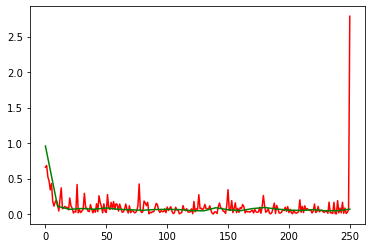

In [19]:
plt.plot(trainloss,c="r")
plt.plot(list(range(0,251,10)),validationloss,c='g')

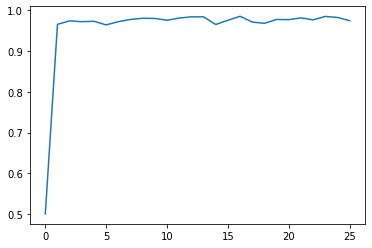

In [20]:
plt.plot(vaccuracy)

In [21]:
#model 2 monkey species
imgloader=datasets.ImageFolder("../input/10-monkey-species/training/training/",transform=transform)
validimgloader=datasets.ImageFolder("../input/10-monkey-species/validation/validation/",transform=transform)

In [22]:
dataloader = torch.utils.data.DataLoader(imgloader, batch_size=32, shuffle=True)
validdataloader = torch.utils.data.DataLoader(validimgloader, batch_size=32, shuffle=True)

In [23]:
model2=newmodel(10)
opt=op.Adam(model2.parameters(),lr=0.0001)
model2=model2.to(device)

In [24]:
trainloss=[]
validationloss=[]
vaccuracy=[]
c=0
for i in tqdm.tqdm(dataloader):
    opt.zero_grad()
    pred=model2(i[0].to(device))
    loss=f.cross_entropy(pred,i[1].to(device))
    loss.backward()
    opt.step()
    trainloss.append(loss.detach().cpu().item())
    print(loss)
    
    if c%10==0:
        print("---------validation_start-----------")
        model2.eval()
        with torch.no_grad():
            j=0
            validloss=[]
            vpred=[]
            vactual=[]
            for m in validdataloader:
                valpred=model2(m[0].to(device))
                vloss=f.cross_entropy(valpred,m[1].to(device))
                validloss.append(vloss.detach().cpu().item())
                vpred.append(valpred.detach().cpu().argmax(-1).numpy())
                vactual.append(m[1].detach().cpu().numpy())
            validationloss.append(sum(validloss)/len(validloss))
            vaccuracy.append(accuracy_score(np.concatenate(vpred),np.concatenate(vactual)))
            del valpred,vloss,vactual
            torch.cuda.empty_cache()
            print("-----------validation_end--------------")
            print("---loss---- ",validationloss[-1])
            print("---validacc---- ",vaccuracy[-1])
        model2.train()
    c+=1

  0%|          | 0/35 [00:00<?, ?it/s]

tensor(2.5460, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


  3%|▎         | 1/35 [00:14<08:00, 14.12s/it]

-----------validation_end--------------
---loss----  2.3560610082414417
---validacc----  0.15808823529411764


  6%|▌         | 2/35 [00:15<03:42,  6.73s/it]

tensor(2.3135, device='cuda:0', grad_fn=<NllLossBackward>)


  9%|▊         | 3/35 [00:16<02:10,  4.07s/it]

tensor(2.4028, device='cuda:0', grad_fn=<NllLossBackward>)


 11%|█▏        | 4/35 [00:18<01:38,  3.17s/it]

tensor(2.1167, device='cuda:0', grad_fn=<NllLossBackward>)


 14%|█▍        | 5/35 [00:20<01:19,  2.65s/it]

tensor(1.9128, device='cuda:0', grad_fn=<NllLossBackward>)


 17%|█▋        | 6/35 [00:21<01:08,  2.37s/it]

tensor(1.9658, device='cuda:0', grad_fn=<NllLossBackward>)


 20%|██        | 7/35 [00:23<01:01,  2.20s/it]

tensor(1.5411, device='cuda:0', grad_fn=<NllLossBackward>)


 23%|██▎       | 8/35 [00:24<00:47,  1.75s/it]

tensor(1.4313, device='cuda:0', grad_fn=<NllLossBackward>)


 26%|██▌       | 9/35 [00:25<00:41,  1.58s/it]

tensor(1.3410, device='cuda:0', grad_fn=<NllLossBackward>)


 29%|██▊       | 10/35 [00:27<00:37,  1.52s/it]

tensor(1.2088, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0131, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 31%|███▏      | 11/35 [00:37<01:39,  4.17s/it]

-----------validation_end--------------
---loss----  1.0808665421273973
---validacc----  0.7610294117647058


 34%|███▍      | 12/35 [00:38<01:16,  3.31s/it]

tensor(1.1540, device='cuda:0', grad_fn=<NllLossBackward>)


 37%|███▋      | 13/35 [00:39<00:59,  2.70s/it]

tensor(0.9399, device='cuda:0', grad_fn=<NllLossBackward>)


 40%|████      | 14/35 [00:42<00:58,  2.77s/it]

tensor(0.7881, device='cuda:0', grad_fn=<NllLossBackward>)


 43%|████▎     | 15/35 [00:44<00:46,  2.33s/it]

tensor(0.7431, device='cuda:0', grad_fn=<NllLossBackward>)


 46%|████▌     | 16/35 [00:45<00:36,  1.92s/it]

tensor(0.7352, device='cuda:0', grad_fn=<NllLossBackward>)


 49%|████▊     | 17/35 [00:47<00:35,  1.98s/it]

tensor(0.6962, device='cuda:0', grad_fn=<NllLossBackward>)


 51%|█████▏    | 18/35 [00:48<00:28,  1.65s/it]

tensor(0.6420, device='cuda:0', grad_fn=<NllLossBackward>)


 54%|█████▍    | 19/35 [00:49<00:24,  1.54s/it]

tensor(0.7052, device='cuda:0', grad_fn=<NllLossBackward>)


 57%|█████▋    | 20/35 [00:50<00:21,  1.43s/it]

tensor(0.5262, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4864, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 60%|██████    | 21/35 [01:03<01:07,  4.79s/it]

-----------validation_end--------------
---loss----  0.4523864487806956
---validacc----  0.9485294117647058


 63%|██████▎   | 22/35 [01:04<00:47,  3.68s/it]

tensor(0.5653, device='cuda:0', grad_fn=<NllLossBackward>)


 66%|██████▌   | 23/35 [01:05<00:35,  2.99s/it]

tensor(0.4054, device='cuda:0', grad_fn=<NllLossBackward>)


 69%|██████▊   | 24/35 [01:06<00:26,  2.42s/it]

tensor(0.4043, device='cuda:0', grad_fn=<NllLossBackward>)


 71%|███████▏  | 25/35 [01:08<00:21,  2.19s/it]

tensor(0.4402, device='cuda:0', grad_fn=<NllLossBackward>)


 74%|███████▍  | 26/35 [01:09<00:15,  1.77s/it]

tensor(0.3175, device='cuda:0', grad_fn=<NllLossBackward>)


 77%|███████▋  | 27/35 [01:10<00:12,  1.53s/it]

tensor(0.2810, device='cuda:0', grad_fn=<NllLossBackward>)


 80%|████████  | 28/35 [01:11<00:09,  1.40s/it]

tensor(0.3774, device='cuda:0', grad_fn=<NllLossBackward>)


 83%|████████▎ | 29/35 [01:12<00:08,  1.47s/it]

tensor(0.2258, device='cuda:0', grad_fn=<NllLossBackward>)


 86%|████████▌ | 30/35 [01:14<00:06,  1.37s/it]

tensor(0.3670, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3228, device='cuda:0', grad_fn=<NllLossBackward>)
---------validation_start-----------


 89%|████████▊ | 31/35 [01:24<00:16,  4.14s/it]

-----------validation_end--------------
---loss----  0.24063691993554434
---validacc----  0.9632352941176471


 91%|█████████▏| 32/35 [01:26<00:09,  3.30s/it]

tensor(0.2968, device='cuda:0', grad_fn=<NllLossBackward>)


 94%|█████████▍| 33/35 [01:27<00:05,  2.76s/it]

tensor(0.2909, device='cuda:0', grad_fn=<NllLossBackward>)


 97%|█████████▋| 34/35 [01:28<00:02,  2.35s/it]

tensor(0.2737, device='cuda:0', grad_fn=<NllLossBackward>)


100%|██████████| 35/35 [01:29<00:00,  2.56s/it]

tensor(0.2723, device='cuda:0', grad_fn=<NllLossBackward>)


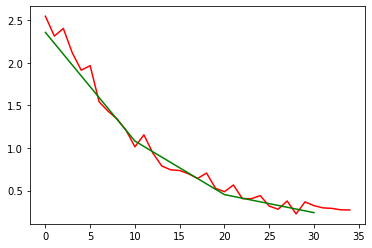

In [25]:
plt.plot(trainloss,c="r")
plt.plot(list(range(0,35,10)),validationloss,c='g')

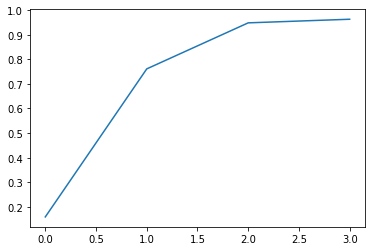

In [26]:
plt.plot(vaccuracy)

In [35]:
#model distillation 
class distillmodel(nn.Module):
    def __init__(self,nclasses):
        super().__init__()
        self.cls=nn.Sequential(*(list(resnet.children())[:-1]))
        self.fc1=nn.Linear(512,nclasses[0])
        self.fc2=nn.Linear(512,nclasses[1])
    
    def forward(self,x,c=0):
        if c==0:
            return self.fc1(self.cls(x).squeeze())
        else:
            return self.fc2(self.cls(x).squeeze())
        

In [36]:
imgloader=datasets.ImageFolder("../input/cat-and-dog/training_set/training_set/",transform=transform)
validimgloader=datasets.ImageFolder("../input/cat-and-dog/test_set/test_set/",transform=transform)
dataloader = torch.utils.data.DataLoader(imgloader, batch_size=32, shuffle=True)
validdataloader = torch.utils.data.DataLoader(validimgloader, batch_size=32, shuffle=True)

In [37]:
#model 2 monkey species
imgloader1=datasets.ImageFolder("../input/10-monkey-species/training/training/",transform=transform)
validimgloader1=datasets.ImageFolder("../input/10-monkey-species/validation/validation/",transform=transform)
dataloader1 = torch.utils.data.DataLoader(imgloader1, batch_size=32, shuffle=True)
validdataloader1 = torch.utils.data.DataLoader(validimgloader1, batch_size=32, shuffle=True)

In [38]:
model3=distillmodel([2,10])

In [39]:
opt3=op.Adam(model3.parameters(),lr=0.0001)

In [40]:
iter1=iter(dataloader)
iter2=iter(dataloader1)

In [41]:
model3=model3.to(device)

In [42]:
trainloss1=[]
trainloss2=[]
validationloss=[]
vaccuracy=[]
c=0
while True:
    i=next(iter1)
    j=next(iter2)
    if i is None or j is None:
        break
    opt3.zero_grad()
    pred=model3(i[0].to(device),c=0)
    pred1=model3(j[0].to(device),c=1)
    loss1=f.cross_entropy(pred,i[1].to(device))
    loss2=f.cross_entropy(pred1,j[1].to(device))
    tloss=loss1+loss2
    tloss.backward()
    opt3.step()
    trainloss1.append(loss1.detach().cpu().item())
    trainloss2.append(loss2.detach().cpu().item())
    c+=1
    print(trainloss1)
    print(trainloss2)
    if c==20:
        break
    

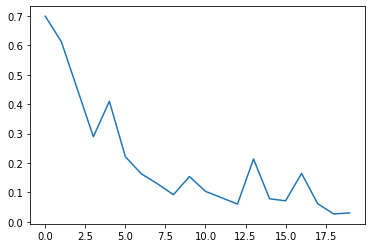

In [43]:
plt.plot(trainloss1)

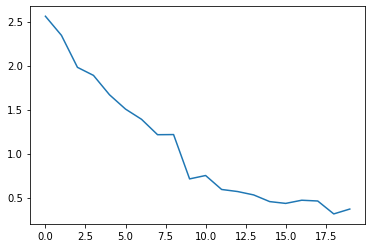

In [44]:
plt.plot(trainloss2)